<a href="https://colab.research.google.com/github/sreeja-g/image-classification-on-american-sign-language-dataset/blob/master/image_classification_on_american_sign_language_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian
project_name = 'image-classification-on-american-sign-language-dataset'

<IPython.core.display.Javascript object>

# Preparing Data

In [ ]:
import os
os.chdir('/kaggle/input/sign-language-mnist/')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

In [ ]:
train_data.shape, test_data.shape

((27455, 785), (7172, 785))

In [ ]:
def dataframe_to_arrays(dataframe):
    
    inputs_array = dataframe.iloc[:, 1:].to_numpy()
    targets_array = dataframe['label'].to_numpy()
    
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(train_data)
inputs_array, targets_array

(array([[107, 118, 127, ..., 204, 203, 202],
        [155, 157, 156, ..., 103, 135, 149],
        [187, 188, 188, ..., 195, 194, 195],
        ...,
        [174, 174, 174, ..., 202, 200, 200],
        [177, 181, 184, ...,  64,  87,  93],
        [179, 180, 180, ..., 205, 209, 215]]),
 array([ 3,  6,  2, ..., 18, 17, 23]))

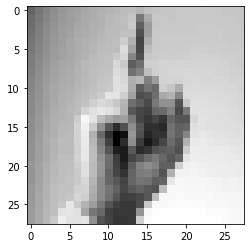

Alphabet :  D


In [ ]:
image = np.reshape(inputs_array[0], (28, 28))
plt.imshow(image, cmap = "gray")
plt.show()

print("Alphabet : ", chr(65+targets_array[0]))

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
inputs = torch.tensor(inputs_array , dtype=torch.float32)
targets = torch.tensor(targets_array , dtype=torch.long)

In [ ]:
dataset = TensorDataset(inputs, targets)

In [ ]:
val_percent = 0.15 
num_rows = train_data.shape[0]

val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
inputs_array_test, targets_array_test = dataframe_to_arrays(test_data)

inputs_test = torch.tensor(inputs_array_test , dtype=torch.float32)
targets_test = torch.tensor(targets_array_test , dtype=torch.long)

test_ds = TensorDataset(inputs_test, targets_test)

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/image-classification-on-american-sign-language-dataset


<IPython.core.display.Javascript object>

# Models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader] 
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    history=[]
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        for batch in train_loader:
            
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
batch_size = 128

## Logistic Regression

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size) 

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[111., 115., 119.,  ..., 188., 173., 143.],
        [130., 134., 139.,  ..., 196., 194., 191.],
        [191., 195., 197.,  ..., 217., 216., 215.],
        ...,
        [191., 191., 192.,  ..., 201., 201., 200.],
        [ 88.,  91.,  93.,  ..., 159., 158., 158.],
        [195., 195., 196.,  ..., 200., 199., 198.]])
targets: tensor([ 3, 20, 20,  8,  8, 10, 16,  5,  7, 22,  4,  5, 15,  7,  3, 12, 12, 11,
         8, 14, 15, 13, 11, 22,  5,  6,  8, 21,  1,  7, 20,  8, 10, 14, 12, 10,
        21,  1,  8, 20, 11, 10, 13, 23,  2, 12, 23, 10,  5, 13,  2, 15,  5, 11,
         2,  5, 19, 20,  0,  7, 14,  3, 13, 22, 12, 23, 21,  8,  5, 11, 16,  0,
        24, 15,  0, 24,  0, 24,  5, 21,  2, 19,  2,  2, 10, 14, 12, 12,  6, 18,
        17, 10,  8, 13,  0, 22, 10,  0,  1,  5, 15,  1, 10, 12,  8, 22,  6, 18,
        18,  8, 19, 20,  2, 19, 17, 19,  6, 22, 14, 11, 13, 23, 19, 17,  2,  4,
         4,  6])


In [ ]:
input_size = 28*28
num_classes = 26

In [ ]:
class aslLogisticRegression(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out
   

In [ ]:
model = aslLogisticRegression()

In [ ]:
evaluate(model, val_loader)

{'val_loss': 217.51661682128906, 'val_acc': 0.05421401560306549}

In [ ]:
learning_rate = 0.0001

In [ ]:
history = fit(70, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 284.7807, val_acc: 0.1964
Epoch [1], val_loss: 302.0431, val_acc: 0.1541
Epoch [2], val_loss: 113.0114, val_acc: 0.2465
Epoch [3], val_loss: 97.2373, val_acc: 0.4191
Epoch [4], val_loss: 72.2428, val_acc: 0.5207
Epoch [5], val_loss: 72.8490, val_acc: 0.5452
Epoch [6], val_loss: 49.6758, val_acc: 0.5594
Epoch [7], val_loss: 64.4416, val_acc: 0.5594
Epoch [8], val_loss: 61.5529, val_acc: 0.5441
Epoch [9], val_loss: 31.4530, val_acc: 0.6267
Epoch [10], val_loss: 87.2438, val_acc: 0.3893
Epoch [11], val_loss: 19.9911, val_acc: 0.7200
Epoch [12], val_loss: 44.4695, val_acc: 0.4833
Epoch [13], val_loss: 27.5902, val_acc: 0.5921
Epoch [14], val_loss: 32.1829, val_acc: 0.5806
Epoch [15], val_loss: 14.1369, val_acc: 0.7892
Epoch [16], val_loss: 7.0380, val_acc: 0.7898
Epoch [17], val_loss: 20.1146, val_acc: 0.7128
Epoch [18], val_loss: 10.1700, val_acc: 0.8038
Epoch [19], val_loss: 28.6137, val_acc: 0.6457
Epoch [20], val_loss: 4.3280, val_acc: 0.8597
Epoch [21], val_loss: 

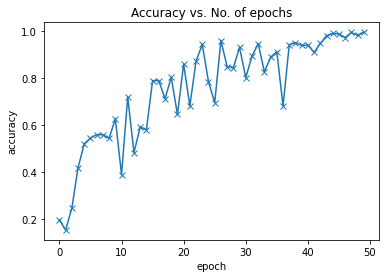

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
result = evaluate(model, test_loader)
result

{'val_loss': 15.590731620788574, 'val_acc': 0.6873629093170166}

## Feedforward Neural Network

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size) 

In [ ]:
input_size = 28*28
hidden_layer1 = 28*14
hidden_layer2 = 100
hidden_layer3 = 50
num_classes = 26

In [ ]:
class ffNeuralNetwork(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_layer1)
        self.linear2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.linear3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.linear4 = nn.Linear(hidden_layer3, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    

In [ ]:
model = ffNeuralNetwork()

In [ ]:
evaluate(model, val_loader)

{'val_loss': 11.512927055358887, 'val_acc': 0.03503787890076637}

In [ ]:
learning_rate = 0.0001

In [ ]:
history = fit(70, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 3.0071, val_acc: 0.1320
Epoch [1], val_loss: 2.8230, val_acc: 0.1656
Epoch [2], val_loss: 2.5423, val_acc: 0.2523
Epoch [3], val_loss: 2.4127, val_acc: 0.2809
Epoch [4], val_loss: 2.2291, val_acc: 0.3363
Epoch [5], val_loss: 2.1269, val_acc: 0.3584
Epoch [6], val_loss: 1.9672, val_acc: 0.4150
Epoch [7], val_loss: 1.8765, val_acc: 0.4482
Epoch [8], val_loss: 1.7665, val_acc: 0.4867
Epoch [9], val_loss: 1.6962, val_acc: 0.5232
Epoch [10], val_loss: 1.6319, val_acc: 0.5203
Epoch [11], val_loss: 1.6740, val_acc: 0.5178
Epoch [12], val_loss: 1.5320, val_acc: 0.5612
Epoch [13], val_loss: 1.4158, val_acc: 0.5922
Epoch [14], val_loss: 1.3809, val_acc: 0.6109
Epoch [15], val_loss: 1.3530, val_acc: 0.6182
Epoch [16], val_loss: 1.2917, val_acc: 0.6266
Epoch [17], val_loss: 1.2425, val_acc: 0.6486
Epoch [18], val_loss: 1.1995, val_acc: 0.6516
Epoch [19], val_loss: 1.1656, val_acc: 0.6700
Epoch [20], val_loss: 1.1203, val_acc: 0.6742
Epoch [21], val_loss: 1.0727, val_acc: 0.701

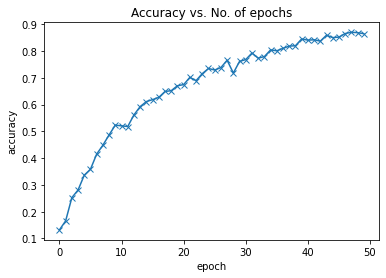

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
result = evaluate(model, test_loader)
result

{'val_loss': 1.225773811340332, 'val_acc': 0.6315789222717285}

# To load Data and Model to GPU 

In [ ]:
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

## Convolution Neural Network

In [ ]:
device = get_default_device()

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_ds, batch_size) 

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [ ]:
num_classes = 26

In [ ]:
class CNNModel(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        
        self.network = nn.Sequential(
        
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 


            nn.Flatten(), 
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        
        )
        
        
    def forward(self, xb):
        
        xb = xb.reshape(-1,1,28,28)
        return self.network(xb)

In [ ]:
model = to_device(CNNModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 3.388793468475342, 'val_acc': 0.045841943472623825}

In [ ]:
learning_rate = 0.0001

In [ ]:
history = fit(70, learning_rate, model, train_dl, val_dl)

Epoch [0], val_loss: 3.0828, val_acc: 0.1696
Epoch [1], val_loss: 2.9858, val_acc: 0.2198
Epoch [2], val_loss: 2.8729, val_acc: 0.2219
Epoch [3], val_loss: 2.7163, val_acc: 0.3036
Epoch [4], val_loss: 2.5688, val_acc: 0.2425
Epoch [5], val_loss: 2.3446, val_acc: 0.3082
Epoch [6], val_loss: 2.1737, val_acc: 0.3346
Epoch [7], val_loss: 2.0714, val_acc: 0.3462
Epoch [8], val_loss: 2.0271, val_acc: 0.3735
Epoch [9], val_loss: 2.2530, val_acc: 0.3200


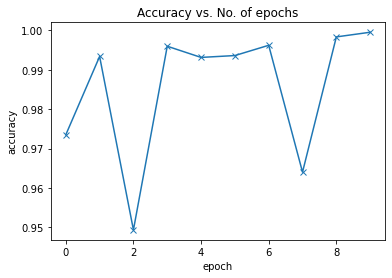

In [ ]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
test_dl = DeviceDataLoader(test_loader, device)

In [ ]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.5021142363548279, 'val_acc': 0.8456688523292542}

In [ ]:
jovian.commit(project=project_name, environment=None)